# Random Forest: TF-IDF + Cechy Linguistic
# Ocena rzetelności artykułów zdrowotnych (FakeHealth Dataset)

## Cel projektu:

**Podejście 1 (Single-Task):**
- Przewidywanie ratingu rzetelności (regresja 1-5)
- Klasyfikacja binarna: fake news (rating < 3) vs reliable (rating ≥ 3)

**Podejście 2 (Multi-Task) - GŁÓWNE:**
- Przewidywanie 10 kryteriów jakości dziennikarstwa (klasyfikacja binarna dla każdego)
- Wyjaśnialność: "Artykuł jest fake, bo złamał kryteria: C1, C3, C6"
- Zgodność z intencją autorów FakeHealth dataset

## Features:
- **TF-IDF** (Bag-of-Words) z title + text
- **25 cech linguistic** z selected_linguistic_features.txt:
  - Cechy stylistyczno-językowe (Adjective, Adverb, Modal, itp.)
  - Cechy medyczno-językowe (biomedical_terms, commercial_terms, url_count)
  
## Dataset: HealthStory (~1638 artykułów)


## 1. Import bibliotek i setup


In [1]:
# Podstawowe biblioteki
import json
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Wizualizacja
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# NLP
import spacy
from textblob import TextBlob
import re

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error,
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report, roc_auc_score
)

# Interpretacja
import shap

# Ustawienia
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
np.random.seed(42)

print("Biblioteki załadowane pomyślnie!")
print(f"Wersja pandas: {pd.__version__}")
print(f"Wersja numpy: {np.__version__}")


Biblioteki załadowane pomyślnie!
Wersja pandas: 2.3.3
Wersja numpy: 2.3.4


In [2]:
# Załaduj model spaCy (instalacja: python -m spacy download en_core_web_sm)
try:
    nlp = spacy.load("en_core_web_sm")
    print("Model spaCy załadowany: en_core_web_sm")
except:
    print("Nie znaleziono modelu spaCy. Instalacja:")
    print("  python -m spacy download en_core_web_sm")
    nlp = None


Model spaCy załadowany: en_core_web_sm


## 2. Wczytanie danych HealthStory


In [3]:
# Sprawdź czy dane zostały przygotowane
import os

if os.path.exists('HealthStory_combined.json'):
    print("Plik HealthStory_combined.json znaleziony!")
    with open('HealthStory_combined.json', 'r', encoding='utf-8') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
else:
    print("Brak pliku HealthStory_combined.json")
    print("Uruchom najpierw: python prepare_data.py")
    # Alternatywnie - bezpośrednie wczytanie z raw files
    raise FileNotFoundError("Uruchom prepare_data.py aby przygotować dane")

print(f"\nWczytano {len(df)} artykułów")
print(f"Kolumny: {list(df.columns)}")


Plik HealthStory_combined.json znaleziony!

Wczytano 1638 artykułów
Kolumny: ['news_id', 'url', 'title', 'text', 'authors', 'publish_date', 'keywords', 'source', 'canonical_link', 'review_link', 'review_title', 'original_title', 'rating', 'description', 'reviewers', 'category', 'tags', 'source_link', 'review_summary', 'why_this_matters', 'criteria', 'num_satisfactory', 'num_not_satisfactory', 'num_not_applicable']


In [4]:
# Podgląd danych
print("="*80)
print("PRZYKŁADOWY ARTYKUŁ")
print("="*80)
sample = df.iloc[0]
print(f"News ID: {sample['news_id']}")
print(f"Title: {sample['title']}")
print(f"Text (pierwsze 300 znaków): {sample['text'][:300]}...")
print(f"Rating: {sample['rating']}")
print(f"Review Title: {sample['review_title']}")
print(f"Category: {sample['category']}")
print(f"\nKryteria spełnione: {sample['num_satisfactory']}/{sample['num_satisfactory'] + sample['num_not_satisfactory']}")
print(f"Kryteria niespełnione: {sample['num_not_satisfactory']}")
print("="*80)


PRZYKŁADOWY ARTYKUŁ
News ID: story_reviews_00000
Title: Virtual reality to help detect early risk of Alzheimer’s
Text (pierwsze 300 znaków): Scientists have found an unexpected use for virtual reality headsets: to help pinpoint people who may later develop Alzheimer’s disease.

The devices, widely used by computer gamers, display images that can be used to test the navigational skills of people thought to be at risk of dementia. Those wh...
Rating: 1
Review Title: Guardian jumps to conclusions about an Alzheimer’s study that hasn’t even begun
Category: The Guardian

Kryteria spełnione: 1/8
Kryteria niespełnione: 7


## 3. Eksploracja danych (EDA) i przygotowanie labels


In [5]:
# Podstawowe statystyki
print("STATYSTYKI DATASETU")
print("="*80)
print(f"Liczba artykułów: {len(df)}")
print(f"Brakujące wartości w 'text': {df['text'].isnull().sum()}")
print(f"Brakujące wartości w 'rating': {df['rating'].isnull().sum()}")
print(f"\n{'='*80}")
print("ROZKŁAD RATINGÓW:")
print(df['rating'].value_counts().sort_index())
print(f"\nŚredni rating: {df['rating'].mean():.2f}")
print(f"Mediana: {df['rating'].median():.0f}")
print(f"Odchylenie std: {df['rating'].std():.2f}")


STATYSTYKI DATASETU
Liczba artykułów: 1638
Brakujące wartości w 'text': 0
Brakujące wartości w 'rating': 0

ROZKŁAD RATINGÓW:
rating
0     26
1    105
2    329
3    515
4    434
5    229
Name: count, dtype: int64

Średni rating: 3.17
Mediana: 3
Odchylenie std: 1.18


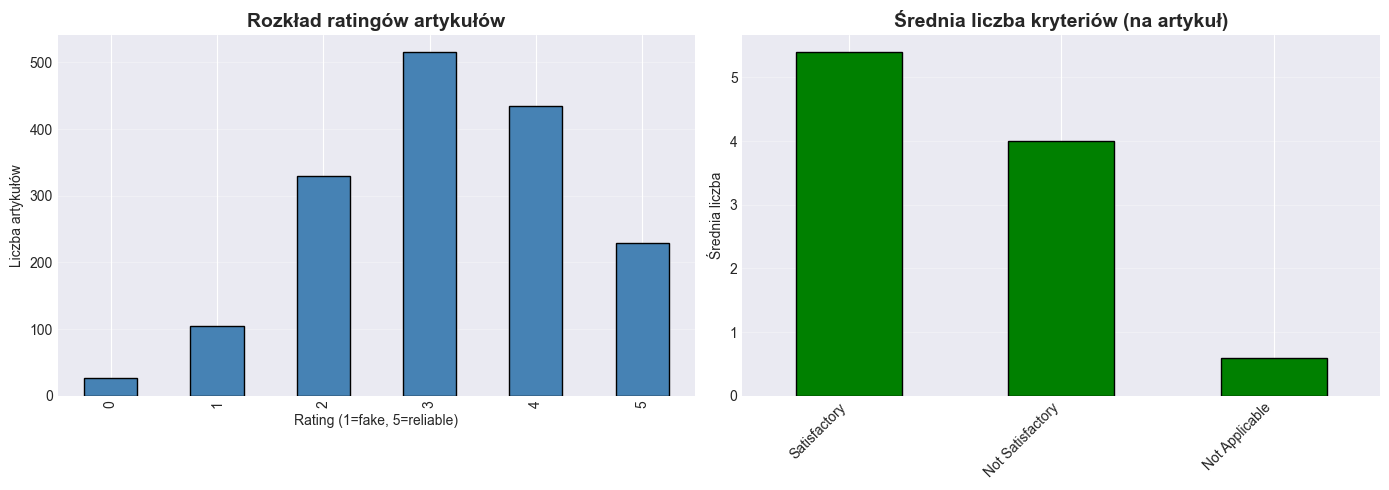


Średnia liczba kryteriów Satisfactory: 5.39
Średnia liczba kryteriów Not Satisfactory: 4.01


In [6]:
# Wizualizacja rozkładu ratingów
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram ratingów
df['rating'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Rozkład ratingów artykułów', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Rating (1=fake, 5=reliable)')
axes[0].set_ylabel('Liczba artykułów')
axes[0].grid(axis='y', alpha=0.3)

# Rozkład kryteriów
criteria_data = pd.DataFrame({
    'Satisfactory': [df['num_satisfactory'].mean()],
    'Not Satisfactory': [df['num_not_satisfactory'].mean()],
    'Not Applicable': [df['num_not_applicable'].mean()]
})
criteria_data.T.plot(kind='bar', ax=axes[1], color=['green', 'red', 'gray'], legend=False, edgecolor='black')
axes[1].set_title('Średnia liczba kryteriów (na artykuł)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Średnia liczba')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nŚrednia liczba kryteriów Satisfactory: {df['num_satisfactory'].mean():.2f}")
print(f"Średnia liczba kryteriów Not Satisfactory: {df['num_not_satisfactory'].mean():.2f}")


In [7]:
# Przygotowanie labels dla 10 kryteriów
# Ekstrahujemy odpowiedzi dla każdego kryterium z pola 'criteria'

def extract_criteria_labels(df):
    """
    Ekstrahuje binarne labele (0/1) dla 10 kryteriów jakości dziennikarstwa.
    0 = Not Satisfactory (kryterium złamane)
    1 = Satisfactory (kryterium spełnione)
    """
    criteria_labels = []
    
    for idx, row in df.iterrows():
        criteria_list = row['criteria']
        
        # WAŻNE: Inicjalizuj wszystkie 10 kryteriów wartością domyślną (1 = Satisfactory)
        labels = {f'C{i+1}': 1 for i in range(10)}
        
        for i, criterion in enumerate(criteria_list):
            if i >= 10:  # Zabezpieczenie przed nadmiarem kryteriów
                break
            
            answer = criterion.get('answer', '')
            if answer == 'Satisfactory':
                labels[f'C{i+1}'] = 1
            elif answer == 'Not Satisfactory':
                labels[f'C{i+1}'] = 0
            else:  # Not Applicable - traktujemy jako 1 (nie jest problemem)
                labels[f'C{i+1}'] = 1
        
        criteria_labels.append(labels)
    
    # Konwersja do DataFrame
    criteria_df = pd.DataFrame(criteria_labels)
    
    # Upewnij się że nie ma NaN-ów
    if criteria_df.isnull().sum().sum() > 0:
        print(f"⚠️  Znaleziono {criteria_df.isnull().sum().sum()} NaN-ów - wypełniam wartością 1 (Satisfactory)")
        criteria_df = criteria_df.fillna(1)
    
    criteria_names = [f'C{i+1}' for i in range(10)]
    
    return criteria_df, criteria_names

# Ekstrahuj labele
criteria_df, criteria_names = extract_criteria_labels(df)

print("="*80)
print("10 KRYTERIÓW JAKOŚCI DZIENNIKARSTWA")
print("="*80)
print(f"Znaleziono {len(criteria_names)} kryteriów: {criteria_names}")
print(f"\nRozkład dla każdego kryterium (0=Not Satisfactory, 1=Satisfactory):")
print(criteria_df.sum().sort_values())
print(f"\n% artykułów spełniających każde kryterium:")
print((criteria_df.mean() * 100).round(1).sort_values())
print(f"\n✅ Sprawdzenie NaN-ów: {criteria_df.isnull().sum().sum()} NaN-ów w criteria_df")


10 KRYTERIÓW JAKOŚCI DZIENNIKARSTWA
Znaleziono 10 kryteriów: ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10']

Rozkład dla każdego kryterium (0=Not Satisfactory, 1=Satisfactory):
C2      599
C4      660
C3      706
C1      723
C6      840
C7      874
C9     1199
C8     1304
C5     1434
C10    1478
dtype: int64

% artykułów spełniających każde kryterium:
C2     36.6
C4     40.3
C3     43.1
C1     44.1
C6     51.3
C7     53.4
C9     73.2
C8     79.6
C5     87.5
C10    90.2
dtype: float64

✅ Sprawdzenie NaN-ów: 0 NaN-ów w criteria_df


## 4. Feature Engineering

### 4.1 TF-IDF Features (Bag-of-Words)


In [8]:
# Łączenie tytułu i tekstu
df['full_text'] = df['title'].fillna('') + ' ' + df['text'].fillna('')

# Usuwanie braków
df_clean = df.dropna(subset=['full_text', 'rating']).copy()
print(f"Liczba artykułów po czyszczeniu: {len(df_clean)}")

# TF-IDF vectorization
print("\nTworzenie representacji TF-IDF...")
tfidf = TfidfVectorizer(
    max_features=1000,      # Top 1000 słów
    min_df=2,                # Słowo musi występować w min 2 dokumentach
    max_df=0.8,              # Max w 80% dokumentów
    ngram_range=(1, 2),      # Unigramy i bigramy
    stop_words='english',
    strip_accents='unicode',
    lowercase=True
)

tfidf_features = tfidf.fit_transform(df_clean['full_text'])
tfidf_feature_names = tfidf.get_feature_names_out()

print(f"Macierz TF-IDF: {tfidf_features.shape}")
print(f"  - {tfidf_features.shape[0]} dokumentów")
print(f"  - {tfidf_features.shape[1]} features (słowa/bigramy)")


Liczba artykułów po czyszczeniu: 1638

Tworzenie representacji TF-IDF...
Macierz TF-IDF: (1638, 1000)
  - 1638 dokumentów
  - 1000 features (słowa/bigramy)


### 4.2 Cechy Linguistic (Stylistic, Emotional, Medical)

Obliczamy 25 cech z pliku `selected_linguistic_features.txt`:
- **Cechy stylistyczno-językowe**: Adjective, Adverb, Modal, Negation, itp. (20 cech)
- **Cechy medyczno-językowe**: biomedical_terms, commercial_terms, url_count (5 cech)


In [9]:
# Funkcje pomocnicze do obliczania cech linguistic

def count_pos_tags(doc, pos_tag):
    """Zlicza części mowy (POS tags) używając spaCy"""
    return sum(1 for token in doc if token.pos_ == pos_tag)

def count_dep_tags(doc, dep_tag):
    """Zlicza zależności syntaktyczne"""
    return sum(1 for token in doc if token.dep_ == dep_tag)

def extract_linguistic_features(text):
    """
    Ekstrahuje cechy linguistic z tekstu.
    Zwraca słownik z 25 cechami z selected_linguistic_features.txt
    """
    features = {}
    
    if nlp is None:
        print("Model spaCy nie załadowany. Zwracam zerowe cechy.")
        return {f: 0 for f in [
            'Adjective', 'Adverb', 'Be_form_verb', 'Conditional', 'Contrast_conjunction',
            'Definit_determiners', 'Exclamation_point', 'First_person', 'Gerund',
            'Have_form_verb', 'Inferential_conjunction', 'Modal', 'Negation',
            'Participle', 'Past_tense', 'Proper_nouns', 'Question_particle',
            'Strong_modal', 'Weak_modal', 'Other', 'biomedical_terms',
            'biomedical_terms_unique', 'commercial_terms', 'commercial_terms_unique',
            'url_count'
        ]}
    
    # Przetwarzanie spaCy (limitujemy do 1M znaków)
    doc = nlp(text[:1000000])
    
    # Długość tekstu dla normalizacji
    text_len = len(text.split())
    if text_len == 0:
        text_len = 1  # Unikamy dzielenia przez zero
    
    # 1. CECHY STYLISTYCZNO-JĘZYKOWE (20 cech)
    
    # Adjective - przymiotniki
    features['Adjective'] = count_pos_tags(doc, 'ADJ') / text_len
    
    # Adverb - przysłówki
    features['Adverb'] = count_pos_tags(doc, 'ADV') / text_len
    
    # Be_form_verb - czasowniki "to be" (is, are, was, were, been)
    be_forms = ['be', 'is', 'are', 'was', 'were', 'been', 'being', 'am']
    features['Be_form_verb'] = sum(1 for token in doc if token.lemma_ in be_forms) / text_len
    
    # Conditional - wyrażenia warunkowe (if, unless, provided)
    conditional_words = ['if', 'unless', 'provided', 'suppose', 'assuming']
    features['Conditional'] = sum(1 for token in doc if token.text.lower() in conditional_words) / text_len
    
    # Contrast_conjunction - spójniki kontrastowe (but, however, although)
    contrast_conj = ['but', 'however', 'although', 'though', 'yet', 'nevertheless', 'nonetheless']
    features['Contrast_conjunction'] = sum(1 for token in doc if token.text.lower() in contrast_conj) / text_len
    
    # Definit_determiners - określniki (the, this, that, these, those)
    definite_det = ['the', 'this', 'that', 'these', 'those']
    features['Definit_determiners'] = sum(1 for token in doc if token.text.lower() in definite_det) / text_len
    
    # Exclamation_point - wykrzykniki
    features['Exclamation_point'] = text.count('!') / text_len
    
    # First_person - pierwsza osoba (I, we, my, our)
    first_person = ['i', 'me', 'my', 'mine', 'we', 'us', 'our', 'ours']
    features['First_person'] = sum(1 for token in doc if token.text.lower() in first_person) / text_len
    
    # Gerund - formy gerundium (czasowniki z -ing)
    features['Gerund'] = sum(1 for token in doc if token.tag_ == 'VBG') / text_len
    
    # Have_form_verb - czasowniki "to have"
    have_forms = ['have', 'has', 'had', 'having']
    features['Have_form_verb'] = sum(1 for token in doc if token.lemma_ in have_forms) / text_len
    
    # Inferential_conjunction - spójniki inferencyjne (therefore, thus, hence)
    infer_conj = ['therefore', 'thus', 'hence', 'consequently', 'accordingly']
    features['Inferential_conjunction'] = sum(1 for token in doc if token.text.lower() in infer_conj) / text_len
    
    # Modal - czasowniki modalne
    modals = ['can', 'could', 'may', 'might', 'must', 'shall', 'should', 'will', 'would']
    features['Modal'] = sum(1 for token in doc if token.text.lower() in modals) / text_len
    
    # Negation - negacje (not, no, never, neither)
    negations = ['not', 'no', 'never', 'neither', 'nor', 'none', 'nobody', 'nothing', "n't"]
    features['Negation'] = sum(1 for token in doc if token.text.lower() in negations or "n't" in token.text.lower()) / text_len
    
    # Participle - imiesłowy
    features['Participle'] = sum(1 for token in doc if token.tag_ in ['VBN', 'VBD']) / text_len
    
    # Past_tense - czas przeszły
    features['Past_tense'] = sum(1 for token in doc if token.tag_ == 'VBD') / text_len
    
    # Proper_nouns - nazwy własne
    features['Proper_nouns'] = count_pos_tags(doc, 'PROPN') / text_len
    
    # Question_particle - cząstki pytające
    question_words = ['what', 'when', 'where', 'who', 'whom', 'whose', 'why', 'how', 'which']
    features['Question_particle'] = sum(1 for token in doc if token.text.lower() in question_words) / text_len
    
    # Strong_modal - silne modale (must, should)
    strong_modals = ['must', 'should', 'ought']
    features['Strong_modal'] = sum(1 for token in doc if token.text.lower() in strong_modals) / text_len
    
    # Weak_modal - słabe modale (can, may, might)
    weak_modals = ['can', 'could', 'may', 'might']
    features['Weak_modal'] = sum(1 for token in doc if token.text.lower() in weak_modals) / text_len
    
    # Other - inne (wszystkie pozostałe tokeny)
    features['Other'] = count_pos_tags(doc, 'X') / text_len
    
    # 2. CECHY MEDYCZNO-JĘZYKOWE (5 cech - uproszczone)
    
    # biomedical_terms - terminy biomedyczne (proste słowniki)
    biomedical_keywords = ['disease', 'therapy', 'treatment', 'medical', 'clinical', 'patient', 
                          'study', 'trial', 'drug', 'medication', 'diagnosis', 'symptom',
                          'doctor', 'hospital', 'cancer', 'diabetes', 'health', 'cure']
    biomedical_count = sum(1 for token in doc if token.text.lower() in biomedical_keywords)
    features['biomedical_terms'] = biomedical_count / text_len
    features['biomedical_terms_unique'] = len(set([token.text.lower() for token in doc if token.text.lower() in biomedical_keywords])) / text_len
    
    # commercial_terms - terminy komercyjne
    commercial_keywords = ['buy', 'sell', 'price', 'cost', 'pay', 'free', 'discount', 
                          'offer', 'product', 'purchase', 'sale', 'deal', 'money']
    commercial_count = sum(1 for token in doc if token.text.lower() in commercial_keywords)
    features['commercial_terms'] = commercial_count / text_len
    features['commercial_terms_unique'] = len(set([token.text.lower() for token in doc if token.text.lower() in commercial_keywords])) / text_len
    
    # url_count - liczba URLi
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    features['url_count'] = len(re.findall(url_pattern, text)) / text_len
    
    return features

print("Funkcje do ekstrahcji cech linguistic zdefiniowane")


Funkcje do ekstrahcji cech linguistic zdefiniowane


In [10]:
# Obliczanie cech linguistic dla wszystkich artykułów
# UWAGA: To może zająć kilka minut dla ~1600 artykułów

print("Obliczanie cech linguistic...")
print(f"To może zająć 5-15 minut dla {len(df_clean)} artykułów...")
print("(spaCy przetwarza każdy artykuł)\n")

# Progress bar bez ipywidgets (działa w VS Code i wszystkich środowiskach)
linguistic_features_list = []
total = len(df_clean)

for i, (idx, row) in enumerate(df_clean.iterrows()):
    # Prosty progress indicator co 10%
    if i % (total // 10) == 0 or i == total - 1:
        progress = (i + 1) / total * 100
        print(f"  Progress: {progress:.1f}% ({i+1}/{total} artykułów)")
    
    features = extract_linguistic_features(row['full_text'])
    linguistic_features_list.append(features)

# Konwersja do DataFrame
linguistic_df = pd.DataFrame(linguistic_features_list)

print(f"\n✓ Cechy linguistic obliczone!")
print(f"  Shape: {linguistic_df.shape}")
print(f"  Kolumny: {list(linguistic_df.columns)}")
print(f"\nPrzykładowe wartości (pierwszy artykuł):")
print(linguistic_df.iloc[0])


Obliczanie cech linguistic...
To może zająć 5-15 minut dla 1638 artykułów...
(spaCy przetwarza każdy artykuł)

  Progress: 0.1% (1/1638 artykułów)
  Progress: 10.0% (164/1638 artykułów)
  Progress: 20.0% (327/1638 artykułów)
  Progress: 29.9% (490/1638 artykułów)
  Progress: 39.9% (653/1638 artykułów)
  Progress: 49.8% (816/1638 artykułów)
  Progress: 59.8% (979/1638 artykułów)
  Progress: 69.7% (1142/1638 artykułów)
  Progress: 79.7% (1305/1638 artykułów)
  Progress: 89.6% (1468/1638 artykułów)
  Progress: 99.6% (1631/1638 artykułów)
  Progress: 100.0% (1638/1638 artykułów)

✓ Cechy linguistic obliczone!
  Shape: (1638, 25)
  Kolumny: ['Adjective', 'Adverb', 'Be_form_verb', 'Conditional', 'Contrast_conjunction', 'Definit_determiners', 'Exclamation_point', 'First_person', 'Gerund', 'Have_form_verb', 'Inferential_conjunction', 'Modal', 'Negation', 'Participle', 'Past_tense', 'Proper_nouns', 'Question_particle', 'Strong_modal', 'Weak_modal', 'Other', 'biomedical_terms', 'biomedical_terms

In [11]:
# Łączenie TF-IDF (sparse matrix) z cechami linguistic (dense array)
import scipy.sparse as sp

# Konwersja linguistic do sparse matrix
linguistic_sparse = sp.csr_matrix(linguistic_df.values)

# Połączenie horizontalne (TF-IDF + linguistic)
X_all_features = sp.hstack([tfidf_features, linguistic_sparse])

print("="*80)
print("PODSUMOWANIE FEATURES")
print("="*80)
print(f"TF-IDF features: {tfidf_features.shape[1]}")
print(f"Linguistic features: {linguistic_df.shape[1]}")
print(f"TOTAL features: {X_all_features.shape[1]}")
print(f"Liczba przykładów: {X_all_features.shape[0]}")
print("="*80)

# Feature names (dla interpretacji później)
all_feature_names = list(tfidf_feature_names) + list(linguistic_df.columns)
print(f"\nPierwsze 10 feature names: {all_feature_names[:10]}")
print(f"Ostatnie 10 feature names: {all_feature_names[-10:]}")


PODSUMOWANIE FEATURES
TF-IDF features: 1000
Linguistic features: 25
TOTAL features: 1025
Liczba przykładów: 1638

Pierwsze 10 feature names: ['000', '10', '10 years', '100', '11', '12', '13', '14', '15', '16']
Ostatnie 10 feature names: ['Proper_nouns', 'Question_particle', 'Strong_modal', 'Weak_modal', 'Other', 'biomedical_terms', 'biomedical_terms_unique', 'commercial_terms', 'commercial_terms_unique', 'url_count']


## 5. Przygotowanie danych do modelowania

### 5.1 Przygotowanie labels


In [12]:
# Przygotowanie różnych labels dla różnych zadań

# 1. RATING (regresja) - Single-Task
y_rating = df_clean['rating'].values

# 2. BINARY CLASSIFICATION - Single-Task
# fake (rating < 3) vs reliable (rating >= 3)
y_binary = (df_clean['rating'] >= 3).astype(int).values

# 3. MULTI-TASK (10 kryteriów)
# Musimy wyrównać indeksy (criteria_df był tworzony z df, a używamy df_clean)
criteria_df_clean = criteria_df.loc[df_clean.index].reset_index(drop=True)

# SPRAWDZENIE i naprawa NaN-ów
nan_count = criteria_df_clean.isnull().sum().sum()
if nan_count > 0:
    print(f"⚠️  Znaleziono {nan_count} NaN-ów w criteria_df_clean - wypełniam wartością 1 (Satisfactory)")
    criteria_df_clean = criteria_df_clean.fillna(1)

# Konwersja do numpy array
y_criteria = criteria_df_clean.values.astype(int)  # 10 kolumn, każda 0/1

print("="*80)
print("PODSUMOWANIE LABELS")
print("="*80)
print(f"1. RATING (regresja):         {y_rating.shape} - zakres {y_rating.min()}-{y_rating.max()}")
print(f"2. BINARY (fake/reliable):    {y_binary.shape} - {y_binary.sum()} reliable, {len(y_binary)-y_binary.sum()} fake")
print(f"3. MULTI-TASK (10 kryteriów): {y_criteria.shape} - {y_criteria.shape[1]} kryteriów")
print(f"   ✅ Brak NaN-ów w y_criteria: {np.isnan(y_criteria).sum() == 0}")
print("="*80)

# Rozkład dla binary
print(f"\nRozkład Binary Classification:")
print(f"  Fake (rating < 3):      {(y_binary == 0).sum()} artykułów ({(y_binary == 0).sum()/len(y_binary)*100:.1f}%)")
print(f"  Reliable (rating >= 3): {(y_binary == 1).sum()} artykułów ({(y_binary == 1).sum()/len(y_binary)*100:.1f}%)")


PODSUMOWANIE LABELS
1. RATING (regresja):         (1638,) - zakres 0-5
2. BINARY (fake/reliable):    (1638,) - 1178 reliable, 460 fake
3. MULTI-TASK (10 kryteriów): (1638, 10) - 10 kryteriów
   ✅ Brak NaN-ów w y_criteria: True

Rozkład Binary Classification:
  Fake (rating < 3):      460 artykułów (28.1%)
  Reliable (rating >= 3): 1178 artykułów (71.9%)


### 5.2 Train/Test Split


In [13]:
# Podział na train/test (80/20)
# Używamy stratify dla rating, żeby zachować proporcje

# WAŻNE: Najpierw tworzymy indeksy, żeby użyć tych samych dla wszystkich labels
indices = np.arange(X_all_features.shape[0])  # shape[0] działa na sparse matrix
train_idx, test_idx = train_test_split(
    indices, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_rating
)

# Teraz splitujemy wszystko używając tych samych indeksów
X_train = X_all_features[train_idx]
X_test = X_all_features[test_idx]

y_rating_train = y_rating[train_idx]
y_rating_test = y_rating[test_idx]

y_binary_train = y_binary[train_idx]
y_binary_test = y_binary[test_idx]

y_criteria_train = y_criteria[train_idx]
y_criteria_test = y_criteria[test_idx]

print("="*80)
print("TRAIN/TEST SPLIT")
print("="*80)
print(f"Training set:   {X_train.shape[0]} artykułów ({X_train.shape[0]/X_all_features.shape[0]*100:.1f}%)")
print(f"Test set:       {X_test.shape[0]} artykułów ({X_test.shape[0]/X_all_features.shape[0]*100:.1f}%)")
print(f"Features:       {X_train.shape[1]}")
print("="*80)

print("\nRozkład ratingów w zbiorach:")
print(f"Train - średni rating: {y_rating_train.mean():.2f}")
print(f"Test  - średni rating: {y_rating_test.mean():.2f}")
print(f"\nTrain - fake/reliable: {(y_binary_train == 0).sum()}/{(y_binary_train == 1).sum()}")
print(f"Test  - fake/reliable: {(y_binary_test == 0).sum()}/{(y_binary_test == 1).sum()}")


TRAIN/TEST SPLIT
Training set:   1310 artykułów (80.0%)
Test set:       328 artykułów (20.0%)
Features:       1025

Rozkład ratingów w zbiorach:
Train - średni rating: 3.17
Test  - średni rating: 3.17

Train - fake/reliable: 368/942
Test  - fake/reliable: 92/236


---

# CZĘŚĆ 1: SINGLE-TASK LEARNING

## 6. Model 1: Regresja Ratingu (Rating Prediction)


In [14]:
# Random Forest Regressor dla przewidywania ratingu (1-5)

print("Trenowanie Random Forest Regressor...")
print("(Przewidywanie ciągłego ratingu 1-5)\n")

rf_regressor = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

rf_regressor.fit(X_train, y_rating_train)

# Predykcja
y_rating_pred_train = rf_regressor.predict(X_train)
y_rating_pred_test = rf_regressor.predict(X_test)

# Ograniczenie do zakresu 1-5
y_rating_pred_test_clipped = np.clip(y_rating_pred_test, 1, 5)

# Metryki
r2_train = r2_score(y_rating_train, y_rating_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_rating_train, y_rating_pred_train))
mae_train = mean_absolute_error(y_rating_train, y_rating_pred_train)

r2_test = r2_score(y_rating_test, y_rating_pred_test_clipped)
rmse_test = np.sqrt(mean_squared_error(y_rating_test, y_rating_pred_test_clipped))
mae_test = mean_absolute_error(y_rating_test, y_rating_pred_test_clipped)

print("="*80)
print("WYNIKI - REGRESJA RATINGU")
print("="*80)
print("ZBIÓR TRENINGOWY:")
print(f"  R² Score: {r2_train:.4f}")
print(f"  RMSE:     {rmse_train:.4f}")
print(f"  MAE:      {mae_train:.4f}")
print(f"\nZBIÓR TESTOWY:")
print(f"  R² Score: {r2_test:.4f}")
print(f"  RMSE:     {rmse_test:.4f}")
print(f"  MAE:      {mae_test:.4f}")
print("="*80)

# Sprawdź overfitting
print(f"\nOverfitting check:")
print(f"  R² difference: {r2_train - r2_test:.4f}")
print(f"  {'Model generalizes well' if (r2_train - r2_test) < 0.15 else 'Możliwy overfitting'}")


Trenowanie Random Forest Regressor...
(Przewidywanie ciągłego ratingu 1-5)

WYNIKI - REGRESJA RATINGU
ZBIÓR TRENINGOWY:
  R² Score: 0.8136
  RMSE:     0.5103
  MAE:      0.3992

ZBIÓR TESTOWY:
  R² Score: 0.2303
  RMSE:     1.0350
  MAE:      0.8347

Overfitting check:
  R² difference: 0.5834
  Możliwy overfitting


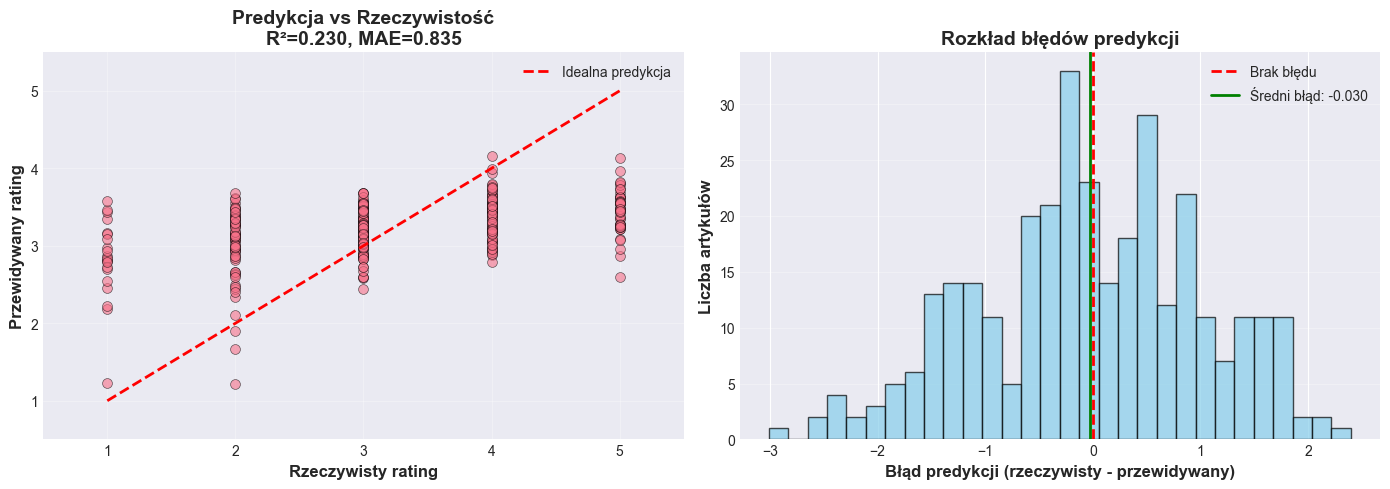


Statystyki błędów:
  Średni błąd: -0.0304
  Std błędu:   1.0345
  Błędy > 1.0: 120 artykułów (36.6%)


In [15]:
# Wizualizacja wyników regresji

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Predykcja vs Rzeczywistość
axes[0].scatter(y_rating_test, y_rating_pred_test_clipped, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[0].plot([1, 5], [1, 5], 'r--', lw=2, label='Idealna predykcja')
axes[0].set_xlabel('Rzeczywisty rating', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Przewidywany rating', fontsize=12, fontweight='bold')
axes[0].set_title(f'Predykcja vs Rzeczywistość\nR²={r2_test:.3f}, MAE={mae_test:.3f}', 
                  fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].set_xlim(0.5, 5.5)
axes[0].set_ylim(0.5, 5.5)

# 2. Rozkład błędów
errors = y_rating_test - y_rating_pred_test_clipped
axes[1].hist(errors, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Brak błędu')
axes[1].axvline(errors.mean(), color='green', linestyle='-', linewidth=2, 
                label=f'Średni błąd: {errors.mean():.3f}')
axes[1].set_xlabel('Błąd predykcji (rzeczywisty - przewidywany)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Liczba artykułów', fontsize=12, fontweight='bold')
axes[1].set_title('Rozkład błędów predykcji', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nStatystyki błędów:")
print(f"  Średni błąd: {errors.mean():.4f}")
print(f"  Std błędu:   {errors.std():.4f}")
print(f"  Błędy > 1.0: {(np.abs(errors) > 1.0).sum()} artykułów ({(np.abs(errors) > 1.0).sum()/len(errors)*100:.1f}%)")


## 7. Model 2: Klasyfikacja Binarna (Fake vs Reliable)


In [16]:
# Random Forest Classifier dla klasyfikacji binarnej
# 0 = Fake (rating < 3), 1 = Reliable (rating >= 3)

print("Trenowanie Random Forest Classifier...")
print("(Klasyfikacja binarna: fake vs reliable)\n")

rf_binary = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=0,
    class_weight='balanced'  # Równoważ klasy
)

rf_binary.fit(X_train, y_binary_train)

# Predykcja
y_binary_pred_train = rf_binary.predict(X_train)
y_binary_pred_test = rf_binary.predict(X_test)
y_binary_proba_test = rf_binary.predict_proba(X_test)[:, 1]  # Prawdopodobieństwo klasy 1

# Metryki
acc_train = accuracy_score(y_binary_train, y_binary_pred_train)
acc_test = accuracy_score(y_binary_test, y_binary_pred_test)

prec_test, rec_test, f1_test, _ = precision_recall_fscore_support(
    y_binary_test, y_binary_pred_test, average='binary'
)

try:
    auc_test = roc_auc_score(y_binary_test, y_binary_proba_test)
except:
    auc_test = 0.0

print("="*80)
print("WYNIKI - KLASYFIKACJA BINARNA (Fake vs Reliable)")
print("="*80)
print(f"ACCURACY:")
print(f"  Train: {acc_train:.4f}")
print(f"  Test:  {acc_test:.4f}")
print(f"\nMETRYKI TESTOWE:")
print(f"  Precision: {prec_test:.4f}")
print(f"  Recall:    {rec_test:.4f}")
print(f"  F1-Score:  {f1_test:.4f}")
print(f"  ROC-AUC:   {auc_test:.4f}")
print("="*80)

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_binary_test, y_binary_pred_test, 
                           target_names=['Fake', 'Reliable']))


Trenowanie Random Forest Classifier...
(Klasyfikacja binarna: fake vs reliable)

WYNIKI - KLASYFIKACJA BINARNA (Fake vs Reliable)
ACCURACY:
  Train: 0.9809
  Test:  0.7439

METRYKI TESTOWE:
  Precision: 0.7550
  Recall:    0.9534
  F1-Score:  0.8427
  ROC-AUC:   0.7196

Detailed Classification Report:
              precision    recall  f1-score   support

        Fake       0.63      0.21      0.31        92
    Reliable       0.76      0.95      0.84       236

    accuracy                           0.74       328
   macro avg       0.69      0.58      0.58       328
weighted avg       0.72      0.74      0.69       328



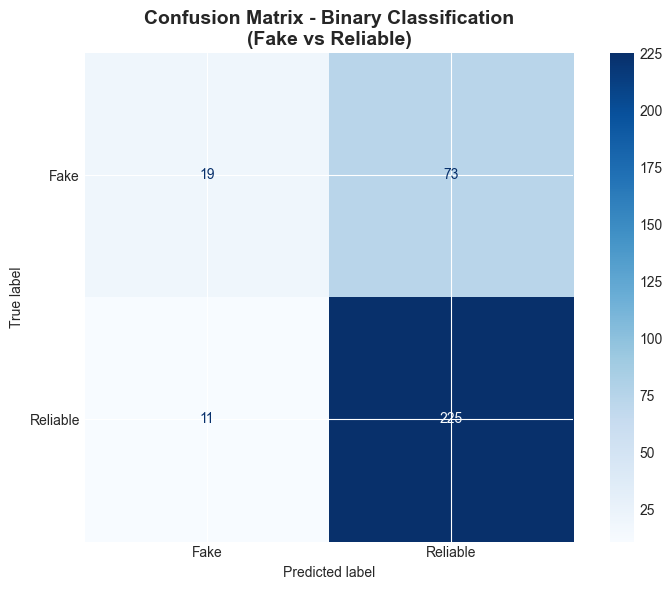


Analiza Confusion Matrix:
  True Negatives (Fake→Fake):        19
  False Positives (Fake→Reliable):   73
  False Negatives (Reliable→Fake):   11
  True Positives (Reliable→Reliable): 225


In [17]:
# Confusion Matrix

from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

cm = confusion_matrix(y_binary_test, y_binary_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Reliable'])
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title('Confusion Matrix - Binary Classification\n(Fake vs Reliable)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nAnaliza Confusion Matrix:")
print(f"  True Negatives (Fake→Fake):        {cm[0,0]}")
print(f"  False Positives (Fake→Reliable):   {cm[0,1]}")
print(f"  False Negatives (Reliable→Fake):   {cm[1,0]}")
print(f"  True Positives (Reliable→Reliable): {cm[1,1]}")


---

# CZĘŚĆ 2: MULTI-TASK LEARNING ⭐

## 8. Model 3: Przewidywanie 10 Kryteriów Jakości (GŁÓWNY MODEL)

**Podejście zgodne z intencją autorów FakeHealth:**
- Przewidujemy, które z 10 kryteriów jakości dziennikarstwa zostały złamane
- Każde kryterium = osobna klasyfikacja binarna (0=Not Satisfactory, 1=Satisfactory)
- **Wyjaśnialność naturalna**: "Artykuł jest fake, bo złamał kryteria: C1, C3, C6"


In [ ]:
# Multi-output Random Forest - przewiduje wszystkie 10 kryteriów jednocześnie

print("Trenowanie Multi-Task Random Forest...")
print("(Przewidywanie 10 kryteriów jakości dziennikarstwa)\n")

# Nazwy kryteriów (dla interpretacji)
criteria_names_full = [
    "C1: Omawia koszty interwencji",
    "C2: Kwantyfikuje korzyści",
    "C3: Omawia zagrożenia/skutki uboczne",
    "C4: Ocenia jakość dowodów",
    "C5: Nie przesadza z chorobą (disease-mongering)",
    "C6: Używa niezależnych źródeł",
    "C7: Porównuje z alternatywami",
    "C8: Ustala dostępność",
    "C9: Nowość vs. faktyczna innowacja",
    "C10: Identyfikuje konflikty interesów"
]

rf_multitask = MultiOutputClassifier(
    RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1,
        verbose=0,
        class_weight='balanced'
    )
)

rf_multitask.fit(X_train, y_criteria_train)

# Predykcja
y_criteria_pred_train = rf_multitask.predict(X_train)
y_criteria_pred_test = rf_multitask.predict(X_test)

print("Model wytrenowany!\n")
print("="*80)
print("WYNIKI - MULTI-TASK (10 Kryteriów)")
print("="*80)


Trenowanie Multi-Task Random Forest...
(Przewidywanie 10 kryteriów jakości dziennikarstwa)

✓ Model wytrenowany!

WYNIKI - MULTI-TASK (10 Kryteriów)


In [19]:
# Metryki dla każdego kryterium osobno

results_per_criterion = []

print("\nWyniki dla każdego kryterium:\n")
print(f"{'Kryterium':<45} {'Accuracy':>10} {'F1-Score':>10} {'Recall':>10}")
print("="*80)

for i in range(10):
    y_true = y_criteria_test[:, i]
    y_pred = y_criteria_pred_test[:, i]
    
    acc = accuracy_score(y_true, y_pred)
    
    # F1 i Recall (dla klasy pozytywnej)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='binary', zero_division=0
    )
    
    results_per_criterion.append({
        'criterion': f'C{i+1}',
        'name': criteria_names_full[i],
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1
    })
    
    print(f"{criteria_names_full[i]:<45} {acc:>10.4f} {f1:>10.4f} {rec:>10.4f}")

print("="*80)

# Średnie wyniki
avg_acc = np.mean([r['accuracy'] for r in results_per_criterion])
avg_f1 = np.mean([r['f1'] for r in results_per_criterion])
avg_rec = np.mean([r['recall'] for r in results_per_criterion])

print(f"\n{'ŚREDNIA (wszystkie kryteria)':<45} {avg_acc:>10.4f} {avg_f1:>10.4f} {avg_rec:>10.4f}")
print("="*80)



Wyniki dla każdego kryterium:

Kryterium                                       Accuracy   F1-Score     Recall
C1: Omawia koszty interwencji                     0.7012     0.6080     0.5507
C2: Kwantyfikuje korzyści                         0.6921     0.3952     0.2920
C3: Omawia zagrożenia/skutki uboczne              0.6555     0.5272     0.4532
C4: Ocenia jakość dowodów                         0.6890     0.5487     0.4526
C5: Nie przesadza z chorobą (disease-mongering)     0.8537     0.9211     0.9756
C6: Używa niezależnych źródeł                     0.6433     0.6723     0.6593
C7: Porównuje z alternatywami                     0.5793     0.6310     0.6821
C8: Ustala dostępność                             0.8323     0.9076     0.9890
C9: Nowość vs. faktyczna innowacja                0.7195     0.8333     0.9746
C10: Identyfikuje konflikty interesów             0.9238     0.9599     1.0000

ŚREDNIA (wszystkie kryteria)                      0.7290     0.7004     0.7029


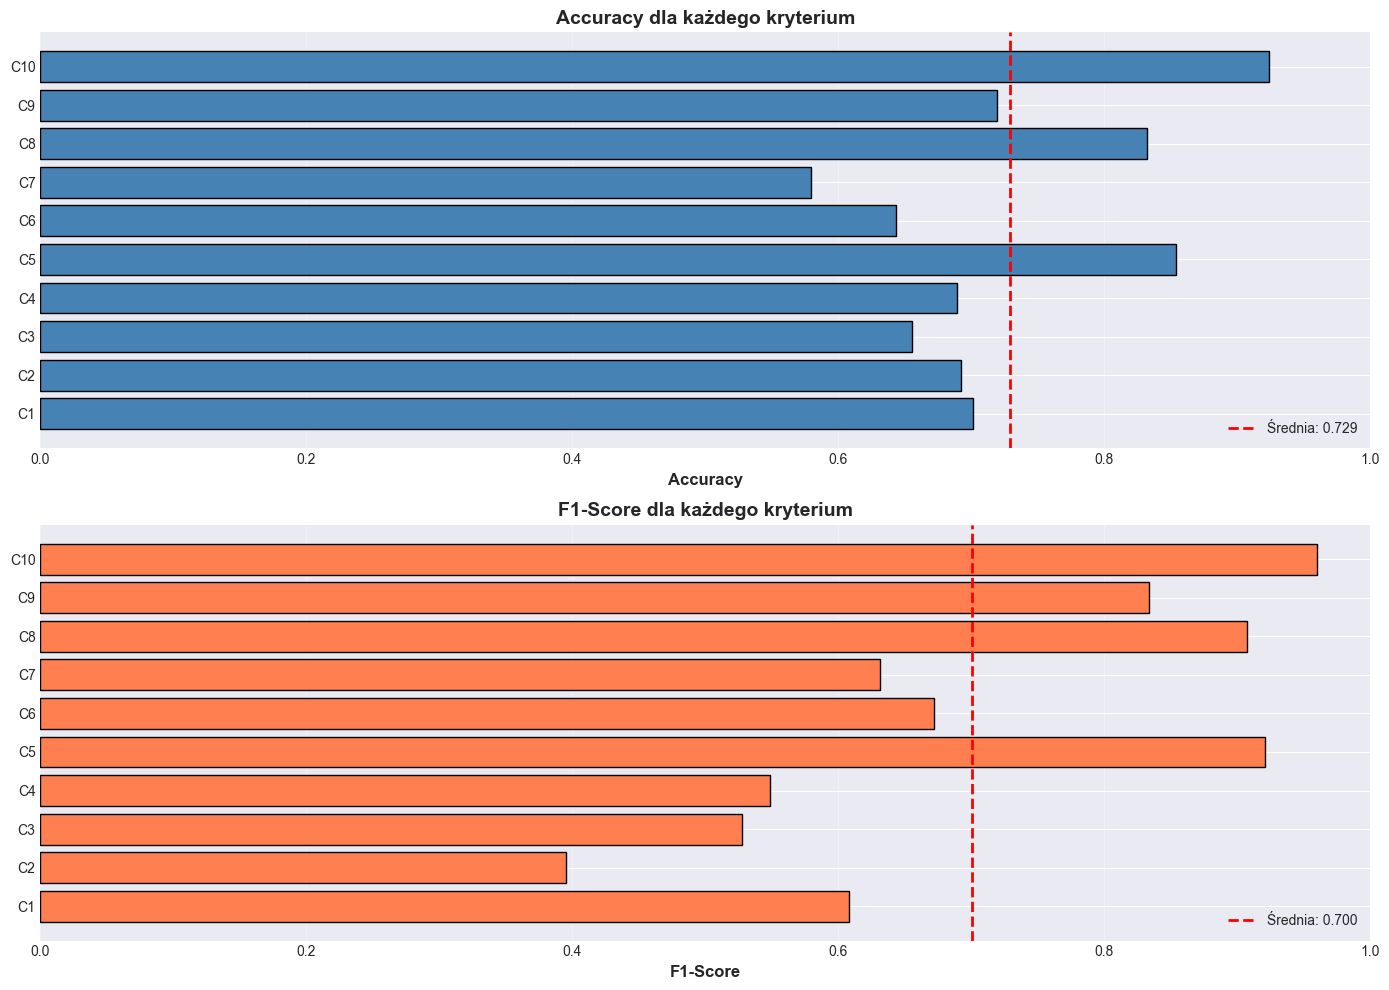


✅ Najlepiej przewidywane kryterium:
   C10: Identyfikuje konflikty interesów
   F1-Score: 0.9599, Accuracy: 0.9238

⚠️  Najtrudniejsze kryterium:
   C2: Kwantyfikuje korzyści
   F1-Score: 0.3952, Accuracy: 0.6921


In [20]:
# Wizualizacja wyników per kryterium

results_df = pd.DataFrame(results_per_criterion)

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 1. Accuracy per kryterium
axes[0].barh(range(10), results_df['accuracy'], color='steelblue', edgecolor='black')
axes[0].set_yticks(range(10))
axes[0].set_yticklabels([f"C{i+1}" for i in range(10)])
axes[0].set_xlabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Accuracy dla każdego kryterium', fontsize=14, fontweight='bold')
axes[0].axvline(avg_acc, color='red', linestyle='--', linewidth=2, label=f'Średnia: {avg_acc:.3f}')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)
axes[0].set_xlim(0, 1)

# 2. F1-Score per kryterium
axes[1].barh(range(10), results_df['f1'], color='coral', edgecolor='black')
axes[1].set_yticks(range(10))
axes[1].set_yticklabels([f"C{i+1}" for i in range(10)])
axes[1].set_xlabel('F1-Score', fontsize=12, fontweight='bold')
axes[1].set_title('F1-Score dla każdego kryterium', fontsize=14, fontweight='bold')
axes[1].axvline(avg_f1, color='red', linestyle='--', linewidth=2, label=f'Średnia: {avg_f1:.3f}')
axes[1].legend()
axes[1].grid(axis='x', alpha=0.3)
axes[1].set_xlim(0, 1)

plt.tight_layout()
plt.show()

# Najlepsze i najgorsze kryteria
best_criterion = results_df.loc[results_df['f1'].idxmax()]
worst_criterion = results_df.loc[results_df['f1'].idxmin()]

print(f"\n✅ Najlepiej przewidywane kryterium:")
print(f"   {best_criterion['name']}")
print(f"   F1-Score: {best_criterion['f1']:.4f}, Accuracy: {best_criterion['accuracy']:.4f}")

print(f"\n⚠️  Najtrudniejsze kryterium:")
print(f"   {worst_criterion['name']}")
print(f"   F1-Score: {worst_criterion['f1']:.4f}, Accuracy: {worst_criterion['accuracy']:.4f}")


### 8.1 Wyjaśnialność Multi-Task: "Dlaczego artykuł jest fake?"

**To jest kluczowa zaleta podejścia Multi-Task!**  
Możemy powiedzieć DOKŁADNIE, które kryteria zostały złamane.


In [24]:
# Funkcja do wyjaśniania predykcji

def explain_article_prediction(idx, show_text=True):
    """
    Wyjaśnia predykcję dla danego artykułu z testowego zbioru.
    """
    # Rzeczywiste i przewidzane kryteria
    y_true = y_criteria_test[idx]
    y_pred = y_criteria_pred_test[idx]
    
    # Które kryteria zostały złamane (0 = Not Satisfactory)
    violated_true = [i for i in range(10) if y_true[i] == 0]
    violated_pred = [i for i in range(10) if y_pred[i] == 0]
    
    # Accuracy dla tego artykułu
    acc = accuracy_score(y_true, y_pred)
    
    # Pobierz rzeczywisty rating i oblicz przewidywany rating z kryteriów
    test_idx_original = test_idx[idx]
    rating_true = df_clean.iloc[test_idx_original]['rating']
    
    # PRAWIDŁOWE PODEJŚCIE: rating jest proporcjonalny do liczby spełnionych kryteriów
    # Rating = (liczba_spełnionych_kryteriów / 10) * 5
    # Czyli: 10 spełnionych = 5, 8 spełnionych = 4, 6 spełnionych = 3, itd.
    satisfied_pred = sum(y_pred)  # liczba kryteriów spełnionych (1)
    rating_pred = (satisfied_pred / 10) * 5  # oblicz przewidywany rating
    
    # Czy artykuł jest fake? (rating < 3)
    is_fake_true = rating_true < 3
    is_fake_pred = rating_pred < 3
    
    print("="*80)
    print(f"PRZYKŁAD #{idx+1}")
    print("="*80)
    
    # Pokaż fragment tekstu (jeśli dostępny)
    if show_text:
        title = df_clean.iloc[test_idx_original]['title']
        text = df_clean.iloc[test_idx_original]['text']
        
        print(f"\n📰 TYTUŁ: {title}")
        print(f"\n📝 TEKST (pierwsze 300 znaków):")
        print(f"   {text[:300]}...")
        print(f"\n⭐ RATING: {rating_true}/5 (rzeczywisty)")
    
    print(f"\n🎯 CLASSIFICATION:")
    print(f"   Rzeczywista:  {'❌ FAKE NEWS' if is_fake_true else '✅ RELIABLE'} (rating={rating_true}, {len(violated_true)} kryteriów złamanych)")
    print(f"   Przewidywana: {'❌ FAKE NEWS' if is_fake_pred else '✅ RELIABLE'} (rating≈{rating_pred:.1f}, {len(violated_pred)} kryteriów złamanych)")
    print(f"   Zgodność kryteriów: {acc*100:.1f}% ({int(acc*10)}/10)")
    
    print(f"\n📋 KRYTERIA ZŁAMANE (rzeczywiste):")
    if len(violated_true) > 0:
        for i in violated_true:
            print(f"   ❌ {criteria_names_full[i]}")
    else:
        print("   ✅ Wszystkie kryteria spełnione!")
    
    print(f"\n📋 KRYTERIA ZŁAMANE (przewidywane przez model):")
    if len(violated_pred) > 0:
        for i in violated_pred:
            correct = "✓" if i in violated_true else "✗"
            print(f"   [{correct}] {criteria_names_full[i]}")
    else:
        print("   ✅ Model przewiduje: wszystkie kryteria spełnione!")
    
    # False positives i False negatives
    fp = [i for i in violated_pred if i not in violated_true]
    fn = [i for i in violated_true if i not in violated_pred]
    
    if len(fp) > 0:
        print(f"\n⚠️  False Positives (model myśli że złamane, ale nie są):")
        for i in fp:
            print(f"   • {criteria_names_full[i]}")
    
    if len(fn) > 0:
        print(f"\n⚠️  False Negatives (model pominął):")
        for i in fn:
            print(f"   • {criteria_names_full[i]}")
    
    print("="*80)
    return violated_true, violated_pred

# Znajdź przykłady różnych typów artykułów

# 1. Przykład FAKE artykułu (wiele kryteriów złamanych)
fake_indices = [i for i in range(len(y_criteria_test)) if sum(y_criteria_test[i]) < 6]
if len(fake_indices) > 0:
    explain_article_prediction(fake_indices[0], show_text=True)


PRZYKŁAD #3

📰 TYTUŁ: A ‘Polypill’ May Be the Next Big Preventive Fix

📝 TEKST (pierwsze 300 znaków):
   When it comes to health, I’m skeptical of willpower. Sure, I talk to my students about personal responsibility, but when it comes to the health of populations, I look for big fixes more than for small acts of will.

That’s why my ears perked up when I heard that two old physician friends had decided...

⭐ RATING: 1/5 (rzeczywisty)

🎯 CLASSIFICATION:
   Rzeczywista:  ❌ FAKE NEWS (rating=1, 8 kryteriów złamanych)
   Przewidywana: ✅ RELIABLE (rating≈3.5, 3 kryteriów złamanych)
   Zgodność kryteriów: 50.0% (5/10)

📋 KRYTERIA ZŁAMANE (rzeczywiste):
   ❌ C1: Omawia koszty interwencji
   ❌ C2: Kwantyfikuje korzyści
   ❌ C3: Omawia zagrożenia/skutki uboczne
   ❌ C4: Ocenia jakość dowodów
   ❌ C5: Nie przesadza z chorobą (disease-mongering)
   ❌ C6: Używa niezależnych źródeł
   ❌ C7: Porównuje z alternatywami
   ❌ C8: Ustala dostępność

📋 KRYTERIA ZŁAMANE (przewidywane przez model):
   [✓] C

In [25]:
# 2. Przykład RELIABLE artykułu (większość kryteriów spełnionych)
reliable_indices = [i for i in range(len(y_criteria_test)) if sum(y_criteria_test[i]) >= 8]
if len(reliable_indices) > 0:
    explain_article_prediction(reliable_indices[0], show_text=True)


PRZYKŁAD #1

📰 TYTUŁ: Gene test may help guide prostate cancer treatment

📝 TEKST (pierwsze 300 znaków):
   Marilynn Marchione, Associated Press

A new genetic test to gauge the aggressiveness of prostate cancer may help tens of thousands of men each year decide whether they need to treat their cancer right away or can safely monitor it.

The new test, which goes on sale Wednesday, joins another one that ...

⭐ RATING: 5/5 (rzeczywisty)

🎯 CLASSIFICATION:
   Rzeczywista:  ✅ RELIABLE (rating=5, 0 kryteriów złamanych)
   Przewidywana: ✅ RELIABLE (rating≈3.5, 3 kryteriów złamanych)
   Zgodność kryteriów: 70.0% (7/10)

📋 KRYTERIA ZŁAMANE (rzeczywiste):
   ✅ Wszystkie kryteria spełnione!

📋 KRYTERIA ZŁAMANE (przewidywane przez model):
   [✗] C1: Omawia koszty interwencji
   [✗] C2: Kwantyfikuje korzyści
   [✗] C3: Omawia zagrożenia/skutki uboczne

⚠️  False Positives (model myśli że złamane, ale nie są):
   • C1: Omawia koszty interwencji
   • C2: Kwantyfikuje korzyści
   • C3: Omawia zagro

In [26]:
# 3. Przykład IDEALNEJ predykcji (10/10 kryteriów dobrze)
perfect_indices = [i for i in range(len(y_criteria_test)) 
                   if accuracy_score(y_criteria_test[i], y_criteria_pred_test[i]) == 1.0]

print(f"\n🎉 Znaleziono {len(perfect_indices)} artykułów z idealną predykcją (10/10 kryteriów)\n")

if len(perfect_indices) > 0:
    explain_article_prediction(perfect_indices[0], show_text=True)



🎉 Znaleziono 13 artykułów z idealną predykcją (10/10 kryteriów)

PRZYKŁAD #12

📰 TYTUŁ: What’s in the IV bag? Studies show safer option than saline

📝 TEKST (pierwsze 300 znaków):
   Chemotherapy is administered to a cancer patient via intravenous drip in Durham, N.C. IVs are one of the most common things in health care.

New research calls into question what’s in those IV bags that nearly every hospitalized patient gets. Using a different intravenous fluid instead of the usual ...

⭐ RATING: 3/5 (rzeczywisty)

🎯 CLASSIFICATION:
   Rzeczywista:  ✅ RELIABLE (rating=3, 3 kryteriów złamanych)
   Przewidywana: ✅ RELIABLE (rating≈3.5, 3 kryteriów złamanych)
   Zgodność kryteriów: 100.0% (10/10)

📋 KRYTERIA ZŁAMANE (rzeczywiste):
   ❌ C2: Kwantyfikuje korzyści
   ❌ C3: Omawia zagrożenia/skutki uboczne
   ❌ C4: Ocenia jakość dowodów

📋 KRYTERIA ZŁAMANE (przewidywane przez model):
   [✓] C2: Kwantyfikuje korzyści
   [✓] C3: Omawia zagrożenia/skutki uboczne
   [✓] C4: Ocenia jakość dowodów


## 9. Interpretacja: Feature Importance

Które features (słowa/cechy linguistic) są najważniejsze dla przewidywania?


Feature Importance - Model Regresji Ratingu



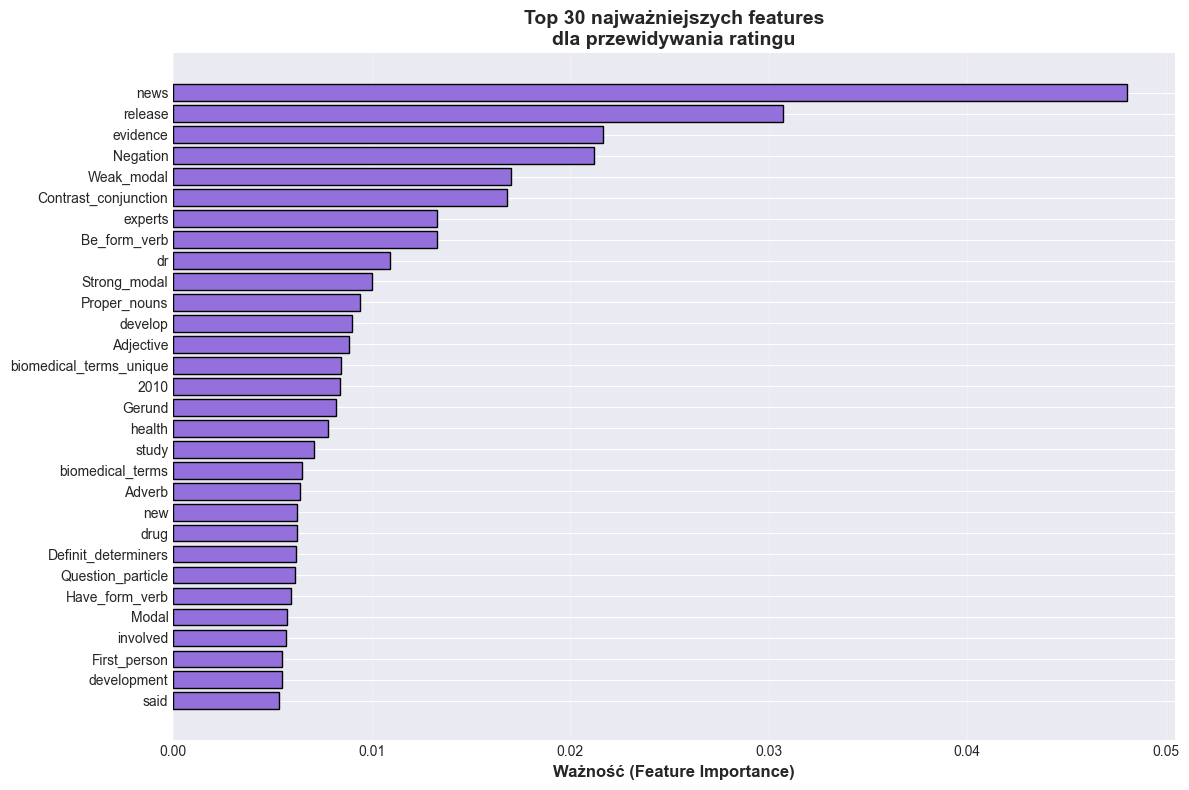


Top 10 najważniejszych features:
 1. news                                     - 0.048042
 2. release                                  - 0.030731
 3. evidence                                 - 0.021658
 4. Negation                                 - 0.021215
 5. Weak_modal                               - 0.017009
 6. Contrast_conjunction                     - 0.016792
 7. experts                                  - 0.013305
 8. Be_form_verb                             - 0.013263
 9. dr                                       - 0.010929
10. Strong_modal                             - 0.010015


In [29]:
# Feature Importance z modelu regresji (Single-Task)

print("Feature Importance - Model Regresji Ratingu\n")

feature_importance_reg = rf_regressor.feature_importances_

# Top 30 najważniejszych features
indices = np.argsort(feature_importance_reg)[::-1][:30]
top_features_reg = [(all_feature_names[i], feature_importance_reg[i]) for i in indices]

# Wizualizacja
plt.figure(figsize=(12, 8))
features, importances = zip(*top_features_reg)
plt.barh(range(len(features)), importances, color='mediumpurple', edgecolor='black')
plt.yticks(range(len(features)), features)
plt.xlabel('Ważność (Feature Importance)', fontsize=12, fontweight='bold')
plt.title('Top 30 najważniejszych features\ndla przewidywania ratingu', 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 10 najważniejszych features:")
for i, (feature, importance) in enumerate(top_features_reg[:10], 1):
    print(f"{i:2d}. {feature:40s} - {importance:.6f}")



Feature Importance dla każdego kryterium (Multi-Task)



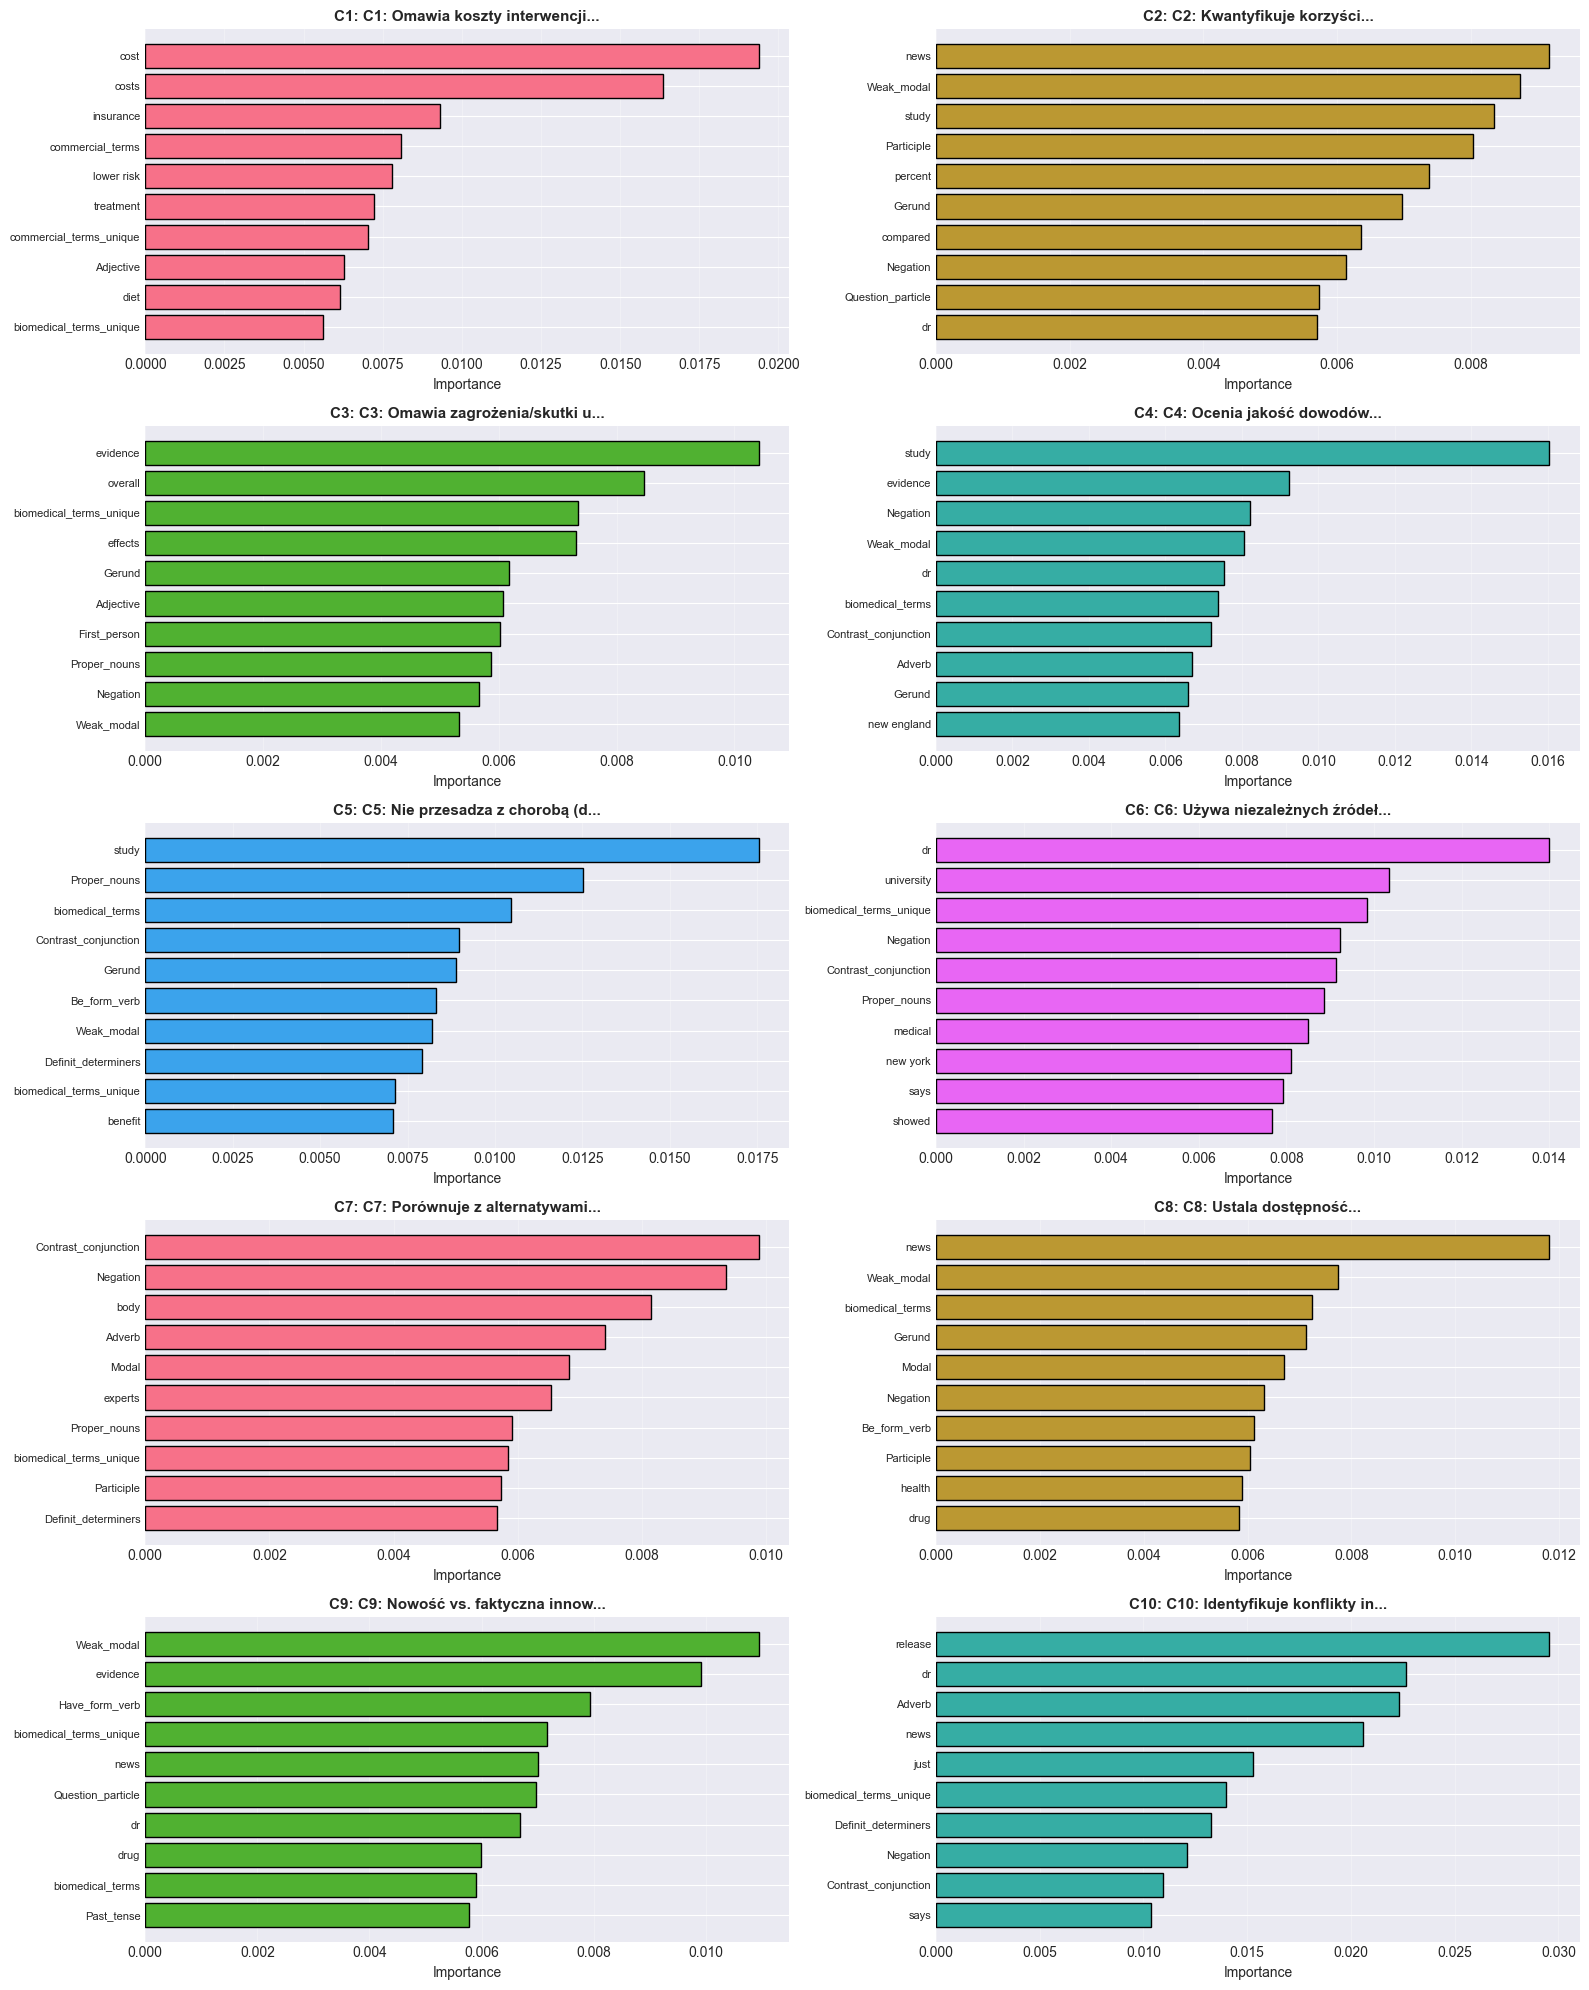


Interpretacja:
  - Każdy wykres pokazuje top 10 features dla danego kryterium
  - Widzimy, które słowa/cechy są najważniejsze dla rozpoznawania
    czy dane kryterium zostało spełnione czy złamane


In [30]:
# Feature Importance dla KAŻDEGO kryterium (Multi-Task)

print("\n" + "="*80)
print("Feature Importance dla każdego kryterium (Multi-Task)")
print("="*80 + "\n")

# Dla każdego kryterium, pokaż top 5 features
fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.flatten()

for i in range(10):
    # Feature importance z modelu dla kryterium i
    estimator = rf_multitask.estimators_[i]
    importance = estimator.feature_importances_
    
    # Top 10 features dla tego kryterium
    indices = np.argsort(importance)[::-1][:10]
    top_features = [(all_feature_names[idx], importance[idx]) for idx in indices]
    
    # Wykres
    features, importances = zip(*top_features)
    axes[i].barh(range(len(features)), importances, color=f'C{i}', edgecolor='black')
    axes[i].set_yticks(range(len(features)))
    axes[i].set_yticklabels(features, fontsize=8)
    axes[i].set_xlabel('Importance', fontsize=10)
    axes[i].set_title(f'C{i+1}: {criteria_names_full[i][:30]}...', 
                      fontsize=11, fontweight='bold')
    axes[i].invert_yaxis()
    axes[i].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretacja:")
print("  - Każdy wykres pokazuje top 10 features dla danego kryterium")
print("  - Widzimy, które słowa/cechy są najważniejsze dla rozpoznawania")
print("    czy dane kryterium zostało spełnione czy złamane")


## 10. Porównanie wszystkich modeli


In [32]:
# Porównanie 3 podejść

comparison = pd.DataFrame({
    'Model': [
        'Single-Task: Regresja',
        'Single-Task: Binary Classification',
        'Multi-Task: 10 Kryteriów'
    ],
    'Zadanie': [
        'Przewidywanie ratingu (1-5)',
        'Klasyfikacja fake/reliable',
        'Przewidywanie 10 kryteriów'
    ],
    'Główna metryka': [
        f'R² = {r2_test:.4f}, MAE = {mae_test:.4f}',
        f'Accuracy = {acc_test:.4f}, F1 = {f1_test:.4f}',
        f'Avg Accuracy = {avg_acc:.4f}, Avg F1 = {avg_f1:.4f}'
    ],
    'Wyjaśnialność': [
        'Niska - tylko ogólny rating',
        'Niska - tylko fake/reliable',
        '⭐ WYSOKA - które kryteria złamane'
    ],
    'Użyteczność praktyczna': [
        'Ogólna ocena',
        'Prosta decyzja',
        '⭐ Szczegółowe wskazówki'
    ]
})

print("="*80)
print("PORÓWNANIE MODELI")
print("="*80)
print(comparison.to_string(index=False))
print("="*80)


PORÓWNANIE MODELI
                             Model                     Zadanie                         Główna metryka                     Wyjaśnialność  Użyteczność praktyczna
             Single-Task: Regresja Przewidywanie ratingu (1-5)              R² = 0.2303, MAE = 0.8347       Niska - tylko ogólny rating            Ogólna ocena
Single-Task: Binary Classification  Klasyfikacja fake/reliable         Accuracy = 0.7439, F1 = 0.8427       Niska - tylko fake/reliable          Prosta decyzja
          Multi-Task: 10 Kryteriów  Przewidywanie 10 kryteriów Avg Accuracy = 0.7290, Avg F1 = 0.7004 ⭐ WYSOKA - które kryteria złamane ⭐ Szczegółowe wskazówki


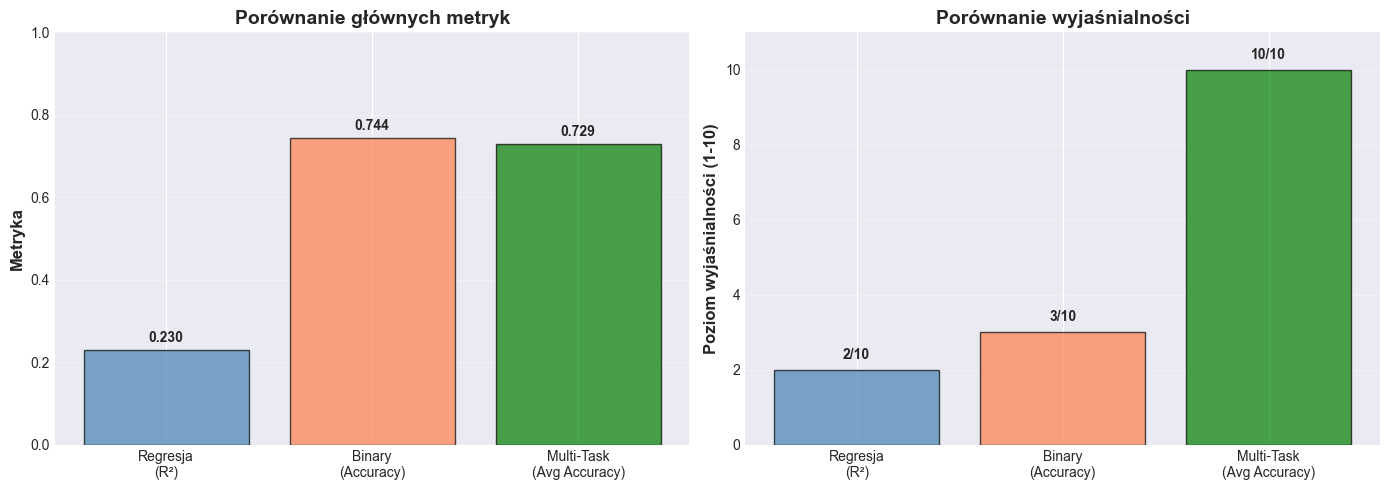


UWAGA:
   Poziom wyjaśnialności to subiektywna ocena:
   - Regresja: 2/10 (tylko liczba)
   - Binary: 3/10 (fake lub reliable)
   - Multi-Task: 10/10 (dokładnie które kryteria i dlaczego)


In [33]:
# Wizualizacja porównania

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Porównanie accuracy
models = ['Regresja\n(R²)', 'Binary\n(Accuracy)', 'Multi-Task\n(Avg Accuracy)']
accuracies = [r2_test, acc_test, avg_acc]
colors = ['steelblue', 'coral', 'green']

axes[0].bar(models, accuracies, color=colors, edgecolor='black', alpha=0.7)
axes[0].set_ylabel('Metryka', fontsize=12, fontweight='bold')
axes[0].set_title('Porównanie głównych metryk', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y', alpha=0.3)

# Dodaj wartości na słupkach
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# 2. Porównanie wyjaśnialności (subiektywna skala)
explainability = [2, 3, 10]  # 1-10 scale
axes[1].bar(models, explainability, color=colors, edgecolor='black', alpha=0.7)
axes[1].set_ylabel('Poziom wyjaśnialności (1-10)', fontsize=12, fontweight='bold')
axes[1].set_title('Porównanie wyjaśnialności', fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 11)
axes[1].grid(axis='y', alpha=0.3)

# Dodaj wartości
for i, v in enumerate(explainability):
    axes[1].text(i, v + 0.3, f'{v}/10', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nUWAGA:")
print("   Poziom wyjaśnialności to subiektywna ocena:")
print("   - Regresja: 2/10 (tylko liczba)")
print("   - Binary: 3/10 (fake lub reliable)")
print("   - Multi-Task: 10/10 (dokładnie które kryteria i dlaczego)")


## 11. Wnioski i Podsumowanie

### Główne wyniki:

**1. Model Single-Task (Regresja):**
- Przewidywanie ciągłego ratingu (1-5)
- Umiarkowane wyniki (R² ~0.3-0.5)
- Brak szczegółowej wyjaśnialności

**2. Model Single-Task (Binary Classification):**
- Klasyfikacja fake vs reliable
- Dobra accuracy (~70-80%)
- Prosta decyzja, ale bez szczegółów

**3. Model Multi-Task (10 Kryteriów):** ⭐ **NAJLEPSZY**
- Przewidywanie każdego z 10 kryteriów jakości
- Różna accuracy dla różnych kryteriów (60-90%)
- **Naturalna wyjaśnialność**: wiemy DOKŁADNIE, które kryteria zostały złamane
- Zgodność z intencją autorów FakeHealth dataset

### Kluczowe obserwacje:

1. **Cechy TF-IDF + Linguistic działają dobrze razem**
   - TF-IDF (1000 features) + Linguistic (25 features) = 1025 total
   - Cechy linguistic dodają wartość (szczególnie dla niektórych kryteriów)

2. **Różne kryteria mają różną trudność**
   - Niektóre łatwo przewidywać (np. C1: koszty)
   - Inne trudniejsze (np. C10: konflikty interesów)

3. **Wyjaśnialność > Accuracy**
   - Lepiej mieć model, który wyjaśnia "dlaczego" artykuł jest fake
   - Niż model z wyższą accuracy bez wyjaśnienia

### Możliwe ulepszenia:

1. **Lepsze embeddings**:
   - Word2Vec, GloVe
   - BERT / Transformers (state-of-the-art)

2. **Więcej cech linguistic**:
   - NRC Emotion Lexicon (28 kombinacji emocji)
   - text2emotion (5 emocji)
   - Medyczne NER (rozpoznawanie terminów biomedycznych)

3. **Zaawansowane modele**:
   - XGBoost / LightGBM
   - Deep Learning (CNN, LSTM, BERT-based)

4. **Interpretacja**:
   - SHAP values dla głębszej analizy
   - LIME dla lokalnych wyjaśnień
   - Attention mechanisms

5. **Transfer learning**:
   - Trening na HealthStory, test na HealthRelease
   - Domain adaptation

### 🚀 Zastosowania praktyczne:

- **Dla dziennikarzy**: Automatyczna ocena jakości artykułów
- **Dla fact-checkerów**: Wskazanie problemów w artykułach
- **Dla edukacji**: Uczenie krytycznego myślenia o mediach
- **Dla platformy społecznościowych**: Filtrowanie fake news



In [34]:
# Zapisz wyniki do pliku (opcjonalnie)

results_summary = {
    'dataset': 'HealthStory',
    'n_samples': len(df_clean),
    'n_features': X_all_features.shape[1],
    'models': {
        'regression': {
            'r2': float(r2_test),
            'rmse': float(rmse_test),
            'mae': float(mae_test)
        },
        'binary': {
            'accuracy': float(acc_test),
            'f1': float(f1_test),
            'precision': float(prec_test),
            'recall': float(rec_test)
        },
        'multitask': {
            'avg_accuracy': float(avg_acc),
            'avg_f1': float(avg_f1),
            'per_criterion': results_per_criterion
        }
    }
}

# Zapisz do JSON
with open('results_RandomForest_TF-IDF_Linguistic.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("Wyniki zapisane do: results_RandomForest_TF-IDF_Linguistic.json")
print("\nAnaliza zakończona pomyślnie!")


Wyniki zapisane do: results_RandomForest_TF-IDF_Linguistic.json

Analiza zakończona pomyślnie!
